In [1]:
# Initialisation(s)

import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/sokoban/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

sys.path.append(f'{global_prefix}../outils')

# [Sokoban](https://fr.wikipedia.org/wiki/Sokoban)
Soit à écrire une fonction `solve`(*file*) prenant en argument un fichier *file* représentant un problème de sokoban au [format xsb](https://fr.wikipedia.org/wiki/Sokoban#Exemple_(le_niveau_1_de_Sokoban)) et renvoyant une chaine de caractère représentant une solution optimale au [format LURD](http://sokoban.org/about_sokoban.php).

Tout d'abord, une fonction `arrayOfFile`(*file*) permettant de représenter le problème par une matrice `numpy`.

In [2]:
import numpy as np
import time

empty = 0
wall = 1
pusher_down = 2
box = 3
goal = 4
box_on_goal = 5
pusher_up = 6
pusher_right = 7
pusher_left = 8


def arrayOfFile(file):
    with open(file,"r") as f: 
            layout = f.readlines() 
    layout = [x.replace('\n','') for x in layout]
    layout = [','.join(layout[i]) for i in range(len(layout))]
    layout = [x.split(',') for x in layout]

    maxColsNum = max([len(x) for x in layout])
    for irow in range(len(layout)):
            for icol in range(len(layout[irow])):
                if layout[irow][icol] == ' ': layout[irow][icol] = empty   
                elif layout[irow][icol] == '#': layout[irow][icol] = wall
                elif layout[irow][icol] == '@': layout[irow][icol] = pusher_down
                elif layout[irow][icol] == '$': layout[irow][icol] = box
                elif layout[irow][icol] == '.': layout[irow][icol] = goal
                elif layout[irow][icol] == '*': layout[irow][icol] = box_on_goal
            colsNum = len(layout[irow])
            if colsNum < maxColsNum:
                layout[irow].extend([0 for _ in range(maxColsNum-colsNum)])            

    return np.array(layout)

Test

In [3]:
microcosmos31_file = f'{global_prefix}/levels/microcosmos31.txt'
arrayOfFile(microcosmos31_file)

array([[0, 0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 5, 1, 0, 1, 1],
       [1, 0, 1, 0, 0, 5, 0, 1],
       [1, 0, 5, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 4, 2, 0, 1],
       [0, 1, 0, 0, 0, 3, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 0]])

Et voici le programme proprement dit qui implémente la fonction `solve`(*file*) en utilisant l'[algorithme A*](../outils/parcours.ipynb).

Noter que les fonctions que l'on donnera en arguments de `aStar` sont issues du programme [sokoban-solver](https://github.com/KnightofLuna/sokoban-solver) de [KnightofLuna](https://github.com/KnightofLuna) ; elles possèdent une doc-string en anglais.

In [4]:
%run ../outils/parcours.ipynb

"""define the rules of sokoban"""

def PosOfPlayer():
    """Return the position of agent"""
    return tuple(np.argwhere(gameState == 2)[0]) # e.g. (2, 2)

def PosOfBoxes():
    """Return the positions of boxes"""
    return tuple(tuple(x) for x in np.argwhere((gameState == 3) | (gameState == 5))) # e.g. ((2, 3), (3, 4), (4, 4), (6, 1), (6, 4), (6, 5))

def PosOfWalls():
    """Return the positions of walls"""
    return tuple(tuple(x) for x in np.argwhere(gameState == 1)) # e.g. like those above

def PosOfGoals():
    """Return the positions of goals"""
    return tuple(tuple(x) for x in np.argwhere((gameState == 4) | (gameState == 5))) # e.g. like those above

def is_end_state(state):
    """Check if all boxes are on the goals (i.e. pass the game)"""
    return sorted(state[1]) == sorted(posGoals)

def isLegalAction(action, posPlayer, posBox):
    """Check if the given action is legal"""
    xPlayer, yPlayer = posPlayer
    if action[-1].isupper(): # the move was a push
        x1, y1 = xPlayer + 2 * action[0], yPlayer + 2 * action[1]
    else:
        x1, y1 = xPlayer + action[0], yPlayer + action[1]
    return (x1, y1) not in posBox + posWalls

def legal_actions(state):
    """Return all legal actions for the agent in the current game state"""
    posPlayer, posBox = state
    allActions = [[-1,0,'u','U'],[1,0,'d','D'],[0,-1,'l','L'],[0,1,'r','R']]
    xPlayer, yPlayer = posPlayer
    legalActions = []
    for action in allActions:
        x1, y1 = xPlayer + action[0], yPlayer + action[1]
        if (x1, y1) in posBox: # the move was a push
            action.pop(2) # drop the little letter
        else:
            action.pop(3) # drop the upper letter
        if isLegalAction(action, posPlayer, posBox):
            legalActions.append(action)
        else: 
            continue     
    return tuple(tuple(x) for x in legalActions) # e.g. ((0, -1, 'l'), (0, 1, 'R'))

def delta(state, action):
    """Return updated game state after an action is taken"""
    posPlayer, posBox = state
    xPlayer, yPlayer = posPlayer # the previous position of player
    newPosPlayer = [xPlayer + action[0], yPlayer + action[1]] # the current position of player
    posBox = [list(x) for x in posBox]
    if action[-1].isupper(): # if pushing, update the position of box
        posBox.remove(newPosPlayer)
        posBox.append([xPlayer + 2 * action[0], yPlayer + 2 * action[1]])
    posBox = tuple(tuple(x) for x in posBox)
    newPosPlayer = tuple(newPosPlayer)
    return newPosPlayer, posBox

def is_blocked(state):
    """This function used to observe if the state is potentially failed, then prune the search"""
    _, posBox = state
    rotatePattern = [[0,1,2,3,4,5,6,7,8],
                    [2,5,8,1,4,7,0,3,6],
                    [0,1,2,3,4,5,6,7,8][::-1],
                    [2,5,8,1,4,7,0,3,6][::-1]]
    flipPattern = [[2,1,0,5,4,3,8,7,6],
                    [0,3,6,1,4,7,2,5,8],
                    [2,1,0,5,4,3,8,7,6][::-1],
                    [0,3,6,1,4,7,2,5,8][::-1]]
    allPattern = rotatePattern + flipPattern

    for box in posBox:
        if box not in posGoals:
            board = [(box[0] - 1, box[1] - 1), (box[0] - 1, box[1]), (box[0] - 1, box[1] + 1), 
                    (box[0], box[1] - 1), (box[0], box[1]), (box[0], box[1] + 1), 
                    (box[0] + 1, box[1] - 1), (box[0] + 1, box[1]), (box[0] + 1, box[1] + 1)]
            for pattern in allPattern:
                newBoard = [board[i] for i in pattern]
                if newBoard[1] in posWalls and newBoard[5] in posWalls: return True
                elif newBoard[1] in posBox and newBoard[2] in posWalls and newBoard[5] in posWalls: return True
                elif newBoard[1] in posBox and newBoard[2] in posWalls and newBoard[5] in posBox: return True
                elif newBoard[1] in posBox and newBoard[2] in posBox and newBoard[5] in posBox: return True
                elif newBoard[1] in posBox and newBoard[6] in posBox and newBoard[2] in posWalls and newBoard[3] in posWalls and newBoard[8] in posWalls: return True
    return False

def heuristic(state):
    """A heuristic function to calculate the overall distance between the else boxes and the else goals"""
    _, posBox = state
    distance = 0
    completes = set(posGoals) & set(posBox)
    sortposBox = list(set(posBox).difference(completes))
    sortposGoals = list(set(posGoals).difference(completes))
    for i in range(len(sortposBox)):
        distance += (abs(sortposBox[i][0] - sortposGoals[i][0])) + (abs(sortposBox[i][1] - sortposGoals[i][1]))
    return distance

def solve(file):
                
    global gameState, posWalls, posGoals

    time_start = time.time()
    gameState = arrayOfFile(file)
    posWalls = PosOfWalls()
    posGoals = PosOfGoals()
    start_state = (PosOfPlayer(), PosOfBoxes())

    sol = aStar(start_state,
                is_end_state,
                legal_actions,
                delta,
                is_blocked,
                heuristic)

    print('Runtime {0:0.2f} seconds'.format(time.time() - time_start))
    return ''.join(list(map(lambda t: t[2], sol)))


Test

In [5]:
microcosmos31_sol = solve(microcosmos31_file)
microcosmos31_sol

Runtime 6.52 seconds


'ruuLuullDllddRRlddrrdrUllluuluurrDuurrddLDDuurrddLdLUrruuluulldllddrddRluuluurrurrddrddllULURddrddlU'

## Représentation graphique d'une solution
### Affichage d'une position

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

matplotlib.rcParams['toolbar'] = 'None'

def imageElement(file):
    return matplotlib.image.imread(f'{global_prefix}images/elements/{file}.png')

imageBox = imageElement('box')
imageGoal = imageElement('goal')
imageEmpty = imageElement('empty')
imageWall = imageElement('wall')
imageBoxOnGoal = imageElement('box-on-goal')
imagePusherDown = imageElement('pusher-down')
imagePusherUp = imageElement('pusher-up')
imagePusherRight = imageElement('pusher-right')
imagePusherLeft = imageElement('pusher-left')

def addElement(ax,image,x,y, zoom = 1.):
    ab = AnnotationBbox(OffsetImage(image, zoom = zoom), 
                        ((32 + x * 64) * zoom, (32 + y * 64) * zoom), 
                        #xycoords = 'axes pixels', 
                        xycoords = 'axes points', 
                        frameon = False)
    ax.add_artist(ab)

def plot_board(M, zoom = 1., name = ''): 

    p = len(M[0])
    q = len(M)
       
    fig = plt.figure(facecolor='black')
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.axis('equal')
    for x in range(p):
        for y in range(q):
            m = M[q - 1 - y, x]
            if m < 0:
                addElement(ax,imageGoal,x,y, zoom = zoom)
            m = abs(m)
            image = imageBox if m == box else \
                    imageGoal if m == goal else \
                    imageEmpty if m == empty else \
                    imageWall if m == wall else \
                    imageBoxOnGoal if m == box_on_goal else \
                    imagePusherDown if m == pusher_down else \
                    imagePusherUp if m == pusher_up else \
                    imagePusherRight if m == pusher_right else \
                    imagePusherLeft
            addElement(ax,image,x,y, zoom = zoom)


    ax.plot()
    if name:
        plt.savefig(name, bbox_inches = 'tight')
        plt.close() # évite l'affichage

Test

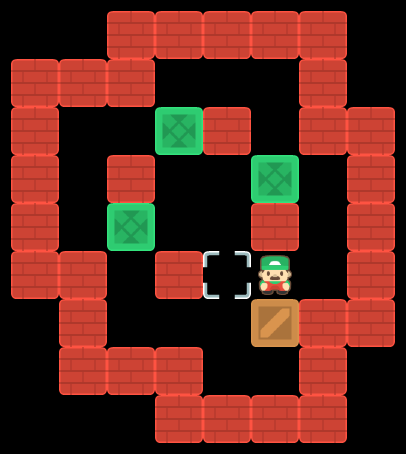

In [7]:
plot_board(arrayOfFile(microcosmos31_file), zoom = .75)

### Enregistrement sur disque des images représentant une solution

In [8]:
def write_solution(M, sol, zoom = 1., name = ''):
    
    plot_board(M, zoom = zoom, name = f'{name}0')
    p = len(M[0])
    q = len(M)
    compteur = 0
    N = M.copy()
    def m(x,y):
        return M[q - 1 - y, x]
    for x in range(p):
        for y in range(q):
            if m(x,y) == pusher_down:
                xPusher, yPusher = x, y
    for l in sol:
        compteur += 1
        llower = l.lower()
        ex, ey, pusher = (0, -1, pusher_down) if llower == 'd' else \
                         (0, 1, pusher_up) if llower == 'u' else \
                         (1, 0, pusher_right) if llower == 'r' else \
                         (-1, 0, pusher_left)
        x0, y0 = xPusher, yPusher
        x1, y1 = x0 + ex, y0 + ey
        x2, y2 = x1 + ex, y1 + ey
        xPusher, yPusher = x1, y1
        N[q - 1 - y0, x0] = goal if m(x0,y0) == goal or m(x0,y0) == box_on_goal else empty
        N[q - 1 - y1, x1] = -pusher if m(x1,y1) == goal or m(x1,y1) == box_on_goal else pusher
        if llower != l:
            N[q - 1 - y2, x2] = box if m(x2,y2) != goal and m(x2,y2) != box_on_goal else box_on_goal
        plot_board(N, zoom = zoom, name = f'{name}{compteur}')
    return compteur

#### forme particularisée de la fonction précédente

In [9]:
def write(name, zoom = 1, sol = '', **kwargs):
    fich = f'{global_prefix}levels/{name}.txt'
    return write_solution(arrayOfFile(fich),  
                            sol if sol else solve(fich, **kwargs), 
                            zoom = zoom,
                            name = f'{global_prefix}images/{name}-')

#### Affichage d'une solution enregistrée

In [10]:
import displayImages


Décommenter une et une seule des trois lignes suivantes

In [11]:
#display_images = displayImages.mpl       # matplotlib.animation
display_images = displayImages.widgets   # ipywidgets.interact  # incompatible avec Google Colab
#display_images = displayImages.cv        # opencv               # incompatible avec Google Colab

In [12]:
def read(name, long):
    return display_images(f'{global_prefix}images/{name}-', long, dpi = 110)

Test

In [13]:
write('microcosmos31', sol = microcosmos31_sol) # 40 s

100

In [14]:
read('microcosmos31', len(microcosmos31_sol))

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

Button(description='▷', style=ButtonStyle())